<a href="https://colab.research.google.com/github/coderbee/AppliedAI/blob/main/GpuSim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem statement
#### Please create a simulator in Python (or other language, if needed) that compares inference performance of H100 (Nvidia) vs MI300 (AMD) vs Inferentia2 (AWS) for Flux-1 (an open-source image model by Black Forest Labs). Please share your notebook (e.g. using Google Colab or Jupyter) and a brief summary (up to 3 pages) of your approach and results. Please focus on images/sec as a metric but specify your assumptions for image resolution, number of iterations etc. Please aim to spend no more than 4-6 hours on this assignment.


#Approach
---
In this colab report I'll share my approach to building a python simulator to compare the performance of different vendor GPU systems that are running a text-to-image workoad like Flux 1.

*  I started working iteratively, so that I always have a working model at each major stage.

*  To begin with, in Stage 1 I  capture the most important hardware features that will affect ML workload performance. Based on this, I develop hardware profiles for the three systems, and build a simple python class based simulation model.
*  In Stage 2, I delve into the characteristics of text-to-image workload like Flux 1. I break down the computation into meaningful steps, and estimate the parameter count and input / output tensor features for each step.

*  In Stage 3, I discuss how the different steps in ML workload map on to hardware components.



#Stage 1: Comparison of hardware capabilities of the three models
---


To begin with, I did a deep dive into the features of the three hardware models. I have compiled the results in the table below.
I identified the following features as the most important based: GPU compute performance (from FP 64 to FP8 ) , VRAM capacity, Memory Bandwidth and interconnect bandwidth. I compiled them below, and plan to incorporate them in my model.


### Important high level features impacting performance:
1. **VRAM**: Essential for fitting large models or processing large batches during inference, minimizing memory swapping.
2. **Memory Bandwidth**: Determines how efficiently the accelerator can handle data transfer during forward passes, directly affecting throughput.
3. **FP64 Performance**: Has negligible impact on inference as high precision is rarely required.
4. **FP32 Performance**: Relevant for models still using FP32 for inference; moderate contribution to performance.
5. **FP8 Performance**: The most relevant metric for cutting-edge inference tasks, where low precision is leveraged for speed and efficiency.
6. **Interconnect Bandwidth**: Critical for setups involving multiple devices or distributed inference workloads.


### Comparison of NVIDIA H100, AMD MI300X, and AWS Inferentia2 for Inference Performance

| Specification             | NVIDIA H100 (SXM) | AMD MI300X           | AWS Inferentia2  |
|----------------------------|-------------------|----------------------|------------------|
| **VRAM**                   | 80 GB HBM3        | 192 GB HBM3          | 32 GiB HBM       |
| **Memory Bandwidth**       | 3.35 TB/s         | 5.3 TB/s             | 820 GB/s         |
| **FP64 Performance**       | 30 TFLOPS         | 46 TFLOPS            | 47.5 TFLOPS      |
| **FP32 Performance**       | 60 TFLOPS         | Not specified        | 47.5 TFLOPS      |
| **FP8 Performance**        | 1,000 TFLOPS      | Not specified        | 190 TFLOPS       |
| **Interconnect Bandwidth** | 900 GB/s (NVLink) | 448 GB/s (xGMI)      | Not specified    |


>References:
AMD, nVIDIA, AWS technical documentation, https://semianalysis.com/2024/12/22/mi300x-vs-h100-vs-h200-benchmark-part-1-training/

In [66]:
########################################
# Hardware profiles for MI300x, H100, and Inferentia2, based on the table created above
########################################
mi300x = {
    "processing_power": 800e12,  # FP8: 800 TFLOPS
    "access_speed": 5300,  # Memory bandwidth: 5.3 TB/s
    "prefill_latency": 0.01,  # Assumed: 10 ms
    "mem_bw": 5300,  # Memory bandwidth: 5.3 TB/s
    "interconnect_bw": 448  # xGMI: 448 GB/s
}

h100 = {
    "processing_power": 1000e12,  # FP8: 1,000 TFLOPS
    "access_speed": 3350,  # Memory bandwidth: 3.35 TB/s
    "prefill_latency": 0.01,  # Assumed: 10 ms
    "mem_bw": 3350,  # Memory bandwidth: 3.35 TB/s
    "interconnect_bw": 900  # NVLink: 900 GB/s
}

inferentia2 = {
    "processing_power": 190e12,  # FP8: 190 TFLOPS
    "access_speed": 820,  # Memory bandwidth: 820 GB/s
    "prefill_latency": 0.01,  # Assumed: 10 ms
    "mem_bw": 820,  # Memory bandwidth: 820 GB/s
    "interconnect_bw": 500  # Not specified (assumed)
}



##Stage 1 : Python model based on hardware features
---
*   **Class based approach** I started off by modeling the componets using a class based approach, this is done so that I can expand the capabilities of the models in subsequent stages. Given more time, a dataflow or a functional model might have been a better (and more performant) approach.
*   I modeled each major component of system as a class, with one function, measureTime. Depending on the component, the measureTime function takes in approproate inputs and produces a result (time in seconds to for that component to execute.
*  Based on the above table about hardware, I created a Hardware profile for each GPU class (H100 vs MI300x vs Inferencia)
*   Calculate total time for a single image text -> vision (summation)
*  Assume data load    


>Assumptions:
*   FP8 performance for MI300x, and Interconnect bandwidth for AWS Inferencia was not publically available, so I made an educated guess.
*  I decided to use FP8 numbers to mode inference capability, assuming the systems are optimized for inference throughput over high fidelity.
*   In this section I assume a generic data load being fed to the systems. In later stages I plan to refine this based on Flux 1 like workloads.
*.  For this stage, I calculate the total time required for generating one image from a text prompt. I do this by simply adding the total time taken by each component(GPU/VRAM/data transfer etc) for each profile (H100, Mi300x, Inferencia). I plan to refine this by modeling the dataflow in subsequent sections.




In [67]:
########################################
# Class based modeling of GPU inference system, highlighting major components
########################################
class GPU:
    def __init__(self, processing_power):
        self.processing_power = processing_power  # e.g., FLOPS

    def measureTime(self, operations):
        """Calculate time based on operations and processing power."""
        return operations / self.processing_power


class VRAM:
    def __init__(self, access_speed):
        self.access_speed = access_speed  # e.g., GB/s

    def measureTime(self, data_size):
        """Calculate time based on data size and access speed."""
        return data_size / self.access_speed


class PrefillGPU:
    def __init__(self, prefill_latency):
        self.prefill_latency = prefill_latency  # e.g., seconds

    def measureTime(self):
        """Return the constant prefill latency."""
        return self.prefill_latency


class MemBW:
    def __init__(self, bandwidth):
        self.bandwidth = bandwidth  # e.g., GB/s

    def measureTime(self, data_size):
        """Calculate time based on data size and memory bandwidth."""
        return data_size / self.bandwidth


class InterconnectBW:
    def __init__(self, bandwidth):
        self.bandwidth = bandwidth  # e.g., GB/s

    def measureTime(self, data_size):
        """Calculate time based on data size and interconnect bandwidth."""
        return data_size / self.bandwidth


class GPUSystem:
    def __init__(self, gpu, vram, prefill_gpu, mem_bw, interconnect_bw):
        self.gpu = gpu
        self.vram = vram
        self.prefill_gpu = prefill_gpu
        self.mem_bw = mem_bw
        self.interconnect_bw = interconnect_bw

    def measureComponentTimes(self, operations, data_size):
        """Calculate the time for each component separately."""
        gpu_time = self.gpu.measureTime(operations)
        vram_time = self.vram.measureTime(data_size)
        prefill_time = self.prefill_gpu.measureTime()
        mem_bw_time = self.mem_bw.measureTime(data_size)
        interconnect_bw_time = self.interconnect_bw.measureTime(data_size)
        return gpu_time, vram_time, prefill_time, mem_bw_time, interconnect_bw_time

    def measureTime(self, operations, data_size):
        """Calculate the total time based on all components."""
        return sum(self.measureComponentTimes(operations, data_size))



## Stage 1: Running model on generic workload




In [68]:


########################################
# Instantiate GPU systems for each profile
########################################

mi300x_system = GPUSystem(
    gpu=GPU(mi300x["processing_power"]),
    vram=VRAM(mi300x["access_speed"]),
    prefill_gpu=PrefillGPU(mi300x["prefill_latency"]),
    mem_bw=MemBW(mi300x["mem_bw"]),
    interconnect_bw=InterconnectBW(mi300x["interconnect_bw"])
)

h100_system = GPUSystem(
    gpu=GPU(h100["processing_power"]),
    vram=VRAM(h100["access_speed"]),
    prefill_gpu=PrefillGPU(h100["prefill_latency"]),
    mem_bw=MemBW(h100["mem_bw"]),
    interconnect_bw=InterconnectBW(h100["interconnect_bw"])
)

inferentia2_system = GPUSystem(
    gpu=GPU(inferentia2["processing_power"]),
    vram=VRAM(inferentia2["access_speed"]),
    prefill_gpu=PrefillGPU(inferentia2["prefill_latency"]),
    mem_bw=MemBW(inferentia2["mem_bw"]),
    interconnect_bw=InterconnectBW(inferentia2["interconnect_bw"])
)
########################################
# Example operations and data size
########################################
operations = 1e10  # 10 billion operations
data_size = 100  # 100 GB

########################################
# Measure component times for each system
########################################
mi300x_times = mi300x_system.measureComponentTimes(operations, data_size)
h100_times = h100_system.measureComponentTimes(operations, data_size)
inferentia2_times = inferentia2_system.measureComponentTimes(operations, data_size)



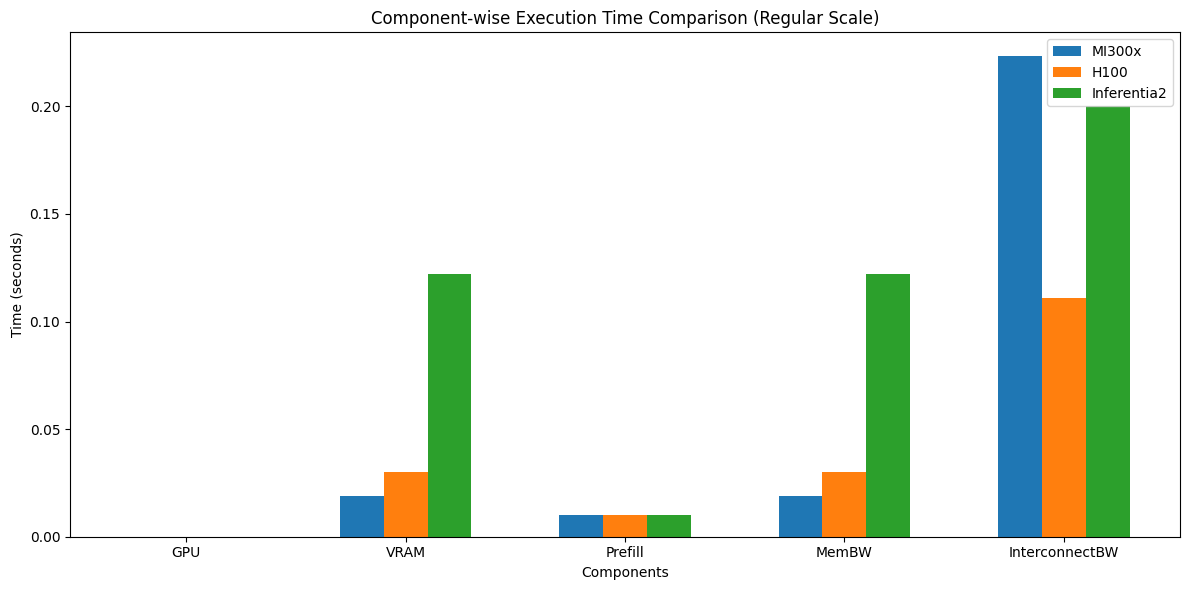

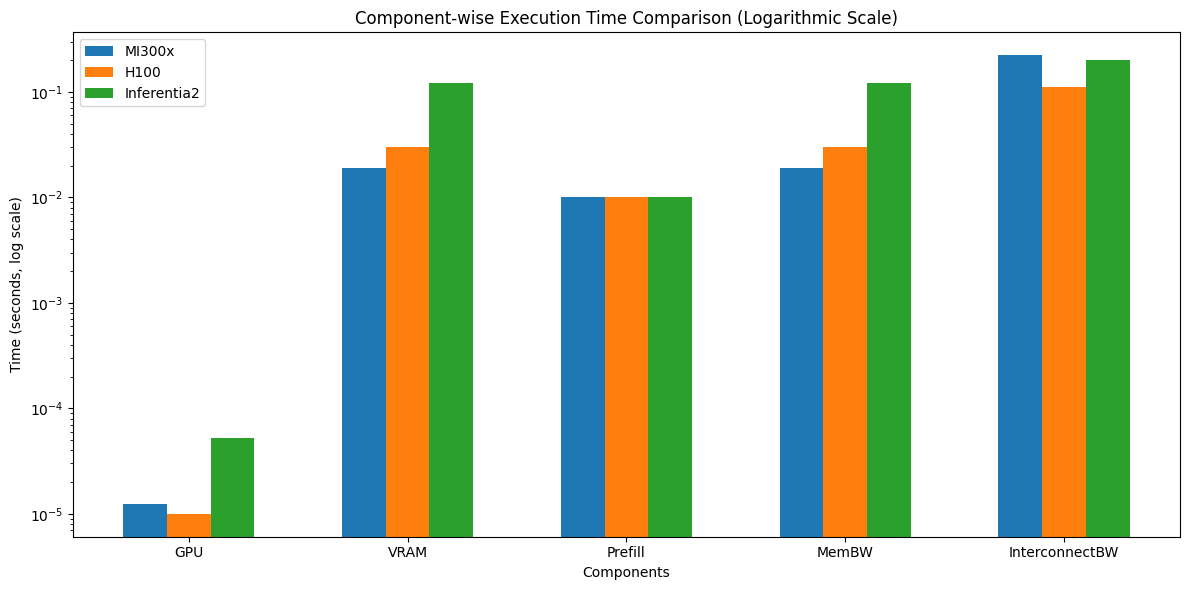

MI300x Total execution time: 0.2709626347708895 seconds
H100 Total execution time: 0.18082260364842453 seconds
Inferentia2 Total execution time: 0.4539550706033376 seconds


In [69]:
########################################
# Generating Plots using matplotlib
########################################
import matplotlib.pyplot as plt

# Labels for profiles and components
profiles = ['MI300x', 'H100', 'Inferentia2']
components = ['GPU', 'VRAM', 'Prefill', 'MemBW', 'InterconnectBW']
all_times = [mi300x_times, h100_times, inferentia2_times]

# Grouped bar graph
x = range(len(components))
width = 0.2

plt.figure(figsize=(12, 6))
for i, times in enumerate(all_times):
    plt.bar([p + i * width for p in x], times, width, label=profiles[i])

plt.xlabel('Components')
plt.ylabel('Time (seconds)')
plt.title('Component-wise Execution Time Comparison (Regular Scale)')
plt.xticks(ticks=[p + width for p in x], labels=components)
plt.legend()
plt.tight_layout()
plt.show()

# Grouped bar graph with logarithmic scale
plt.figure(figsize=(12, 6))
for i, times in enumerate(all_times):
    plt.bar([p + i * width for p in x], times, width, label=profiles[i])

plt.xlabel('Components')
plt.ylabel('Time (seconds, log scale)')
plt.title('Component-wise Execution Time Comparison (Logarithmic Scale)')
plt.yscale('log')
plt.xticks(ticks=[p + width for p in x], labels=components)
plt.legend()
plt.tight_layout()
plt.show()

# Print total execution times
mi300x_total_time = sum(mi300x_times)
h100_total_time = sum(h100_times)
inferentia2_total_time = sum(inferentia2_times)

print(f"MI300x Total execution time: {mi300x_total_time} seconds")
print(f"H100 Total execution time: {h100_total_time} seconds")
print(f"Inferentia2 Total execution time: {inferentia2_total_time} seconds")

## Stage 1: Code run insights
---
*   GPU performance is very fast (order of magnitude more than time due to gpu-vram and interconnect memory bandwidth)
*   Based on raw hardware specifications, the performance of MI300x and H100 seems to be comparable



#Stage 2: Understanding Flux 1 architecture
---


#Multi-model Diffusion based Model Architecture

In this stage I try to refine the default data workload used before (10 billion operations and 100 GB data input) to be more representative of Flux 1 like image-to-text workloads.

> Assumption:
While the Flux 1 Schnell model is open source, the architecture details were not easily available. After a detailed search for a breakdown of its components (mainly trying to understand the stage-wise *number of parameters* and *arithmetic intensity*, I focused on the closest text-to-image diffusion-based model with a widely available internal architecture. I decided to look into GLIDE (Guided Language-to-Image Diffusion for Generation and Editing) as a representative workload. GLIDE is a text-to-image generation system that uses a diffusion-based approach to create high-quality images from textual descriptions. The following analysis outlines its various stages, including parameter counts and input/output tensor sizes for each stage.


## Stage 2: Explanation of Workload stages and Complexity


| **Stage**                   | **Parameters**        | **Input Tensor**       | **Output Tensor**      | **Arithmetic Complexity**      |
|-----------------------------|-----------------------|-------------------------|-------------------------|---------------------------------|
| **Text Encoding**           | ~1.2B                | `[B, L]`               | `[B, L, D]`            | `O(B * L * D^2)`               |
| **Base Image Generation**    | ~2.3B                | `[B, C, 64, 64]`       | `[B, C, 64, 64]`       | `O(T * B * F * C^2)`           |
| **Upsampling**               | ~1.5B                | `[B, C, 64, 64]`       | `[B, C, 256, 256]`     | `O(T * B * F' * C^2)`          |
| **Classifier-Free Guidance** | None                 | `[B, C, H, W]`         | `[B, C, H, W]`         | `O(B * C * H * W)`             |


1. **Text Encoding**: Converts the input text prompt into dense embeddings using a transformer-based model, such as a pre-trained CLIP text encoder.
   - Dominant Operations: Transformer-based operations, primarily matrix multiplications in attention and feedforward layers.
   - Complexity: `O(B * L * D^2)`, where `B` is batch size, `L` is sequence length, and `D` is embedding dimension.

2. **Base Image Generation**: Uses the embeddings from the text encoding stage as conditioning input to a U-Net model, which performs iterative denoising to generate a low-resolution image (64x64).
   - Dominant Operations: Convolutions and attention layers across diffusion timesteps `T`.
   - Complexity: `O(T * B * F * C^2)`, where `T` is the number of diffusion steps, `F = H * W` is the spatial resolution, and `C` is the number of channels in the U-Net.

3. **Upsampling**: Takes the low-resolution image from the base generation stage and refines it to a high-resolution image (256x256) using an upsampling diffusion model.
   - Dominant Operations: Similar to base generation, with larger spatial resolution `F'` (e.g., `256 * 256`).
   - Complexity: `O(T * B * F' * C^2)`, where `F'` represents the larger resolution.

4. **Classifier-Free Guidance**: Combines outputs conditioned on text embeddings with unconditioned outputs to improve fidelity to the input text prompt.
   - Dominant Operations: Arithmetic operations combining conditioned and unconditioned outputs.
   - Complexity: `O(B * C * H * W)`, where `H * W` is the resolution.

*   Definition of T and F:
T: Number of diffusion steps (e.g., 1000 steps). The arithmetic complexity scales linearly with T as each step involves denoising.
F: Spatial resolution of the image in terms of pixels, calculated as F = H * W. For 64x64 resolution, F = 64 * 64 = 4096.



* Assuming FP8, 1 billion parameters would take 1 GB space.

## Stage 2: From Parameters, I/O tensors to TFOPS and bytes
In this step I try to estimate the number of operations based on the arithmetic complexity.
>Assumption:
For the sake of simplicity I choose the scaling constant to be 1. The exact value of scaling constant could be better determined by profiling a realistic text to image application for select few examples.

For e.g for **Text Encoding**, Based on the complexity `O(B * L * D^2)`, where `B=16`, `L=77`, and `D=2048`, Operation Count = 16 * 77 * 2048^2 ~ 5 trillion FLOPS. A similar procedure is used to estimate Data size, based on input/output tensor sizes.

| Stage                      | Operation Count        | Data Size               | Time Steps (T) | Arithmetic Intensity (FLOPs/byte) | Hardware Components Used                                  |
|----------------------------|------------------------|-------------------------|----------------|------------------------------------|----------------------------------------------------------|
| Text Encoding              | 5.248 trillion FLOPs  | ~25 MB                 | N/A            | ~200 GFLOPs/byte                  | VRAM (tokenized text, embeddings), GPU compute units, cache |
| Base Image Generation       | 16.777 trillion FLOPs | ~4 GB                  | 1000           | ~4.2 FLOPs/byte                   | VRAM (U-Net weights, tensors), Tensor cores, GPU compute |
| Upsampling                 | 268.435 trillion FLOPs| ~64 GB                 | 1000           | ~4.2 FLOPs/byte                   | VRAM (upsampler weights, tensors), Tensor cores, GPU compute |
| Classifier-Free Guidance   | 3.145 million FLOPs   | ~3 MB                  | N/A            | ~1 FLOP/byte                      | VRAM (outputs), GPU compute units, cache                |



###Output of this stage is to get Profile Info




In [70]:

#####################################################
# DERIVED ML system profiles for text to Image conversion
#####################################################
ml_profile = MLProfile(
    text_encoding=(5.248e12, 0.025),  # 5.248 trillion operations, 25 MB data size
    base_image_generation=(1.6777e13, 4),  # 16.777 trillion operations, 4 GB data size
    upsampling=(2.68435e14, 64),  # 268.435 trillion operations, 64 GB data size
    classifier_free_guidance=(3.145e6, 0.003)  # 3.145 million operations, 3 MB data size
)


#Stage 3: Mapping ML workload to hardware

Performance of a system depends on mapping a workoad to hardware. There could be many ways to map the stages of an ML workoad onto hardware running in a GPU cloud system. I'll breifly discuss a few of them in context of previous text-to-image model

>Profile 1: Similar to current LLM applicatoins mapped to GPU systems, the initial text encoding (prefill) stage may be done separately from the rest of the steps.

>Profile 2: The differnet ML steps may be spread across GPU's in different racks and even across different datacenters, incurring differnt inferconnect bandwidth related delays.

Given the time limit, I assume a simple mapping profile according to the following datapath:
> Prefill (GPU + VRAM) -> Memory BW -> Base Image Generation (GPU + VRAM) -> Memory BW -> Upsampling (GPU + VRAM) -> Memory BW -> CFG (GPU + VRAM)



In [71]:
########################################
# Defining four stages of text to image ML system
# Creating a 'TextToImageSystem' class to put all components together
########################################
class TextEncoding:
    def __init__(self, profile):
        self.gpu = GPU(profile["processing_power"])
        self.vram = VRAM(profile["access_speed"])
        self.mem_bw = MemBW(profile["mem_bw"])

    def measureTime(self, operations, data_size):
        gpu_time = self.gpu.measureTime(operations)
        vram_time = self.vram.measureTime(data_size)
        mem_bw_time = self.mem_bw.measureTime(data_size)
        return gpu_time + vram_time + mem_bw_time


class BaseImageGeneration:
    def __init__(self, profile):
        self.gpu = GPU(profile["processing_power"])
        self.vram = VRAM(profile["access_speed"])
        self.mem_bw = MemBW(profile["mem_bw"])

    def measureTime(self, operations, data_size):
        gpu_time = self.gpu.measureTime(operations)
        vram_time = self.vram.measureTime(data_size)
        mem_bw_time = self.mem_bw.measureTime(data_size)
        return gpu_time + vram_time + mem_bw_time


class Upsampling:
    def __init__(self, profile):
        self.gpu = GPU(profile["processing_power"])
        self.vram = VRAM(profile["access_speed"])
        self.mem_bw = MemBW(profile["mem_bw"])

    def measureTime(self, operations, data_size):
        gpu_time = self.gpu.measureTime(operations)
        vram_time = self.vram.measureTime(data_size)
        mem_bw_time = self.mem_bw.measureTime(data_size)
        return gpu_time + vram_time + mem_bw_time


class ClassifierFreeGuidance:
    def __init__(self, profile):
        self.gpu = GPU(profile["processing_power"])
        self.vram = VRAM(profile["access_speed"])
        self.mem_bw = MemBW(profile["mem_bw"])

    def measureTime(self, operations, data_size):
        gpu_time = self.gpu.measureTime(operations)
        vram_time = self.vram.measureTime(data_size)
        mem_bw_time = self.mem_bw.measureTime(data_size)
        return gpu_time + vram_time + mem_bw_time

class MLProfile:
    def __init__(self, text_encoding, base_image_generation, upsampling, classifier_free_guidance):
        """Profile for ML workload stages with (operations, data_size) sets."""
        self.text_encoding = text_encoding
        self.base_image_generation = base_image_generation
        self.upsampling = upsampling
        self.classifier_free_guidance = classifier_free_guidance


class TextToImageSystem:
    def __init__(self, profile):
        self.text_encoding = TextEncoding(profile)
        self.base_image_generation = BaseImageGeneration(profile)
        self.upsampling = Upsampling(profile)
        self.classifier_free_guidance = ClassifierFreeGuidance(profile)

    def measureComponentTimes(self, ml_profile):
        """Measure times for each stage in the Text to Image system."""
        text_encoding_time = self.text_encoding.measureTime(*ml_profile.text_encoding)
        base_image_generation_time = self.base_image_generation.measureTime(*ml_profile.base_image_generation)
        upsampling_time = self.upsampling.measureTime(*ml_profile.upsampling)
        classifier_free_guidance_time = self.classifier_free_guidance.measureTime(*ml_profile.classifier_free_guidance)
        return text_encoding_time, base_image_generation_time, upsampling_time, classifier_free_guidance_time

    def measureTime(self, ml_profile):
        """Calculate total time for the Text to Image system."""
        return sum(self.measureComponentTimes(ml_profile))

# Example ML profile for workload
'''ml_profile = MLProfile(
    text_encoding=(1e10, 50),  # 10 billion operations, 50 GB data size
    base_image_generation=(2e10, 100),  # 20 billion operations, 100 GB data size
    upsampling=(1e9, 25),  # 1 billion operations, 25 GB data size
    classifier_free_guidance=(5e9, 10)  # 5 billion operations, 10 GB data size
)
'''


# Instantiations for MI300x, H100, and Inferentia2 systems
systems = {
    "MI300x": TextToImageSystem(mi300x),
    "H100": TextToImageSystem(h100),
    "Inferentia2": TextToImageSystem(inferentia2)
}

# Measure and print results for each system
for name, system in systems.items():
    component_times = system.measureComponentTimes(ml_profile)
    total_time = system.measureTime(ml_profile)
    print(f"{name} Text Encoding Time: {component_times[0]} seconds")
    print(f"{name} Base Image Generation Time: {component_times[1]} seconds")
    print(f"{name} Upsampling Time: {component_times[2]} seconds")
    print(f"{name} Classifier Free Guidance Time: {component_times[3]} seconds")
    print(f"{name} Total Time: {total_time} seconds\n")

MI300x Text Encoding Time: 0.0065694339622641516 seconds
MI300x Base Image Generation Time: 0.022480683962264148 seconds
MI300x Upsampling Time: 0.35969469339622634 seconds
MI300x Classifier Free Guidance Time: 1.1360067216981135e-06 seconds
MI300x Total Time: 0.38874594732747636 seconds

H100 Text Encoding Time: 0.005262925373134328 seconds
H100 Base Image Generation Time: 0.019165059701492536 seconds
H100 Upsampling Time: 0.30664395522388055 seconds
H100 Classifier Free Guidance Time: 1.794189776119403e-06 seconds
H100 Total Time: 0.33107373448828353 seconds

Inferentia2 Text Encoding Time: 0.027682028241335047 seconds
Inferentia2 Base Image Generation Time: 0.09805609756097562 seconds
Inferentia2 Upsampling Time: 1.568913350449294 seconds
Inferentia2 Classifier Free Guidance Time: 7.333625802310655e-06 seconds
Inferentia2 Total Time: 1.6946588098774071 seconds



## Stage 3: Plotting results

MI300x Text Encoding Time: 0.0065694339622641516 seconds
MI300x Base Image Generation Time: 0.022480683962264148 seconds
MI300x Upsampling Time: 0.35969469339622634 seconds
MI300x Classifier Free Guidance Time: 1.1360067216981135e-06 seconds
MI300x Total Time: 0.38874594732747636 seconds

H100 Text Encoding Time: 0.005262925373134328 seconds
H100 Base Image Generation Time: 0.019165059701492536 seconds
H100 Upsampling Time: 0.30664395522388055 seconds
H100 Classifier Free Guidance Time: 1.794189776119403e-06 seconds
H100 Total Time: 0.33107373448828353 seconds

Inferentia2 Text Encoding Time: 0.027682028241335047 seconds
Inferentia2 Base Image Generation Time: 0.09805609756097562 seconds
Inferentia2 Upsampling Time: 1.568913350449294 seconds
Inferentia2 Classifier Free Guidance Time: 7.333625802310655e-06 seconds
Inferentia2 Total Time: 1.6946588098774071 seconds



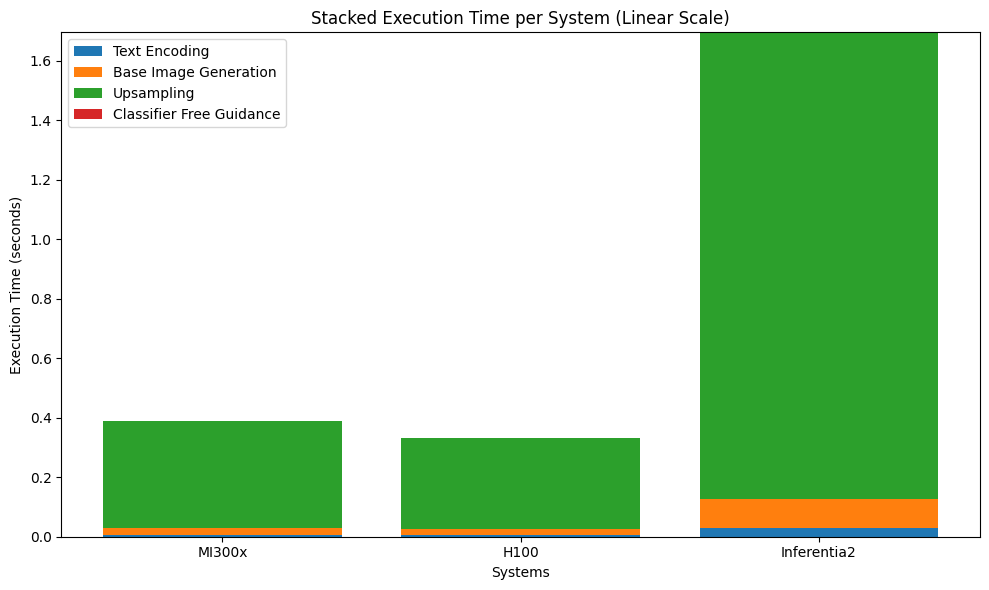

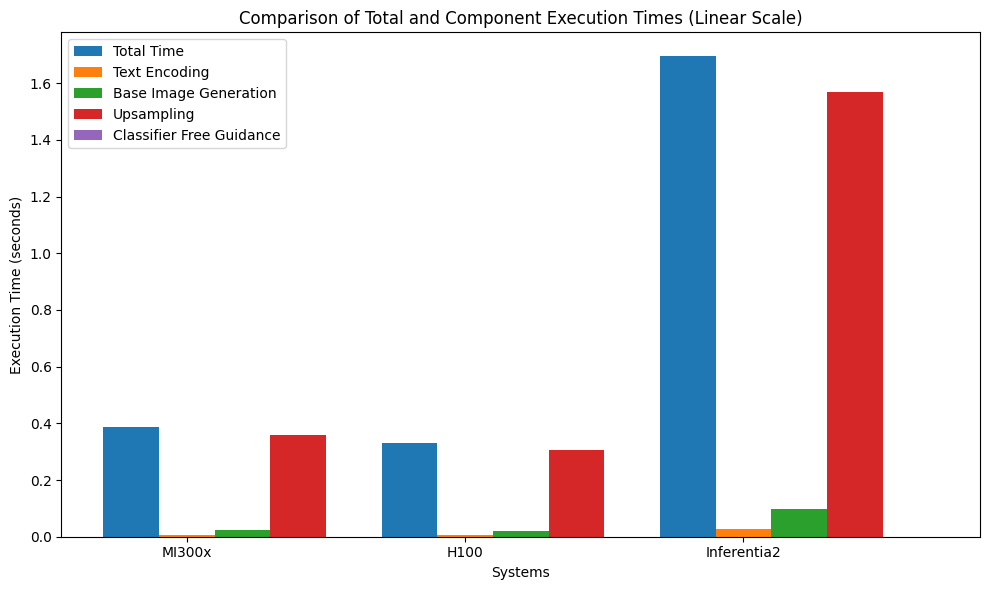

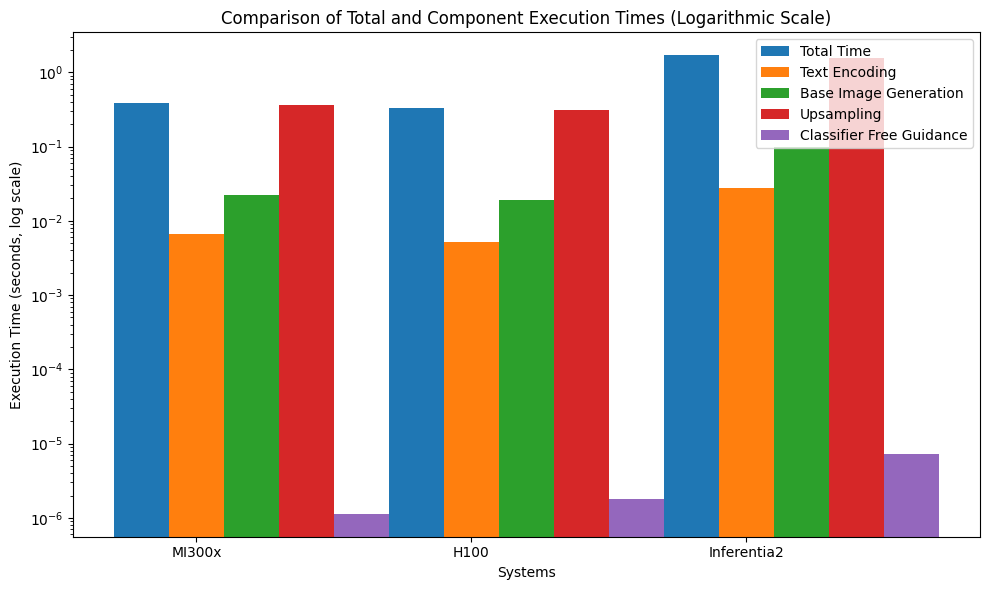

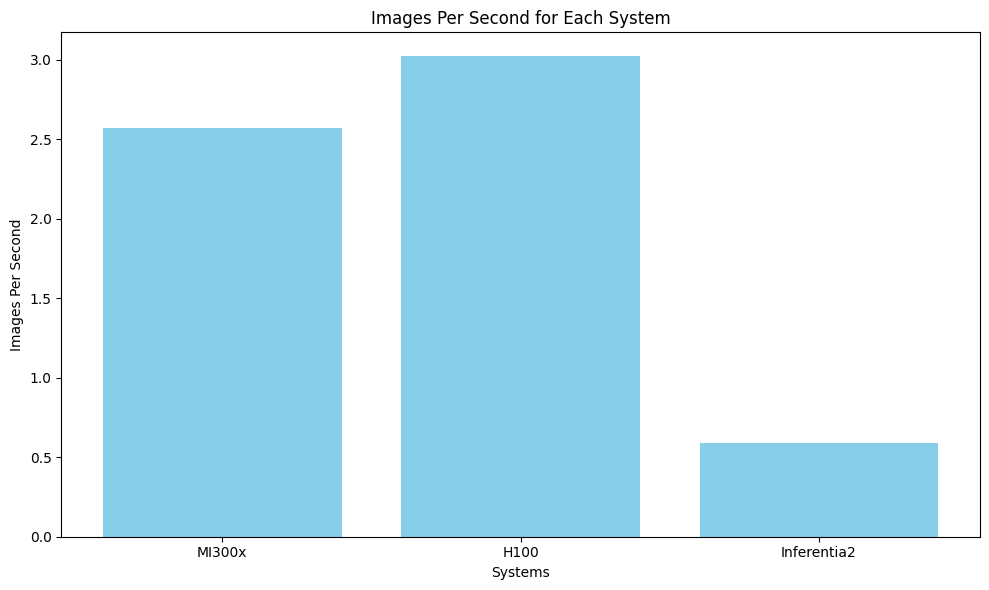

In [72]:
# Measure and print results for each system
system_names = []
total_times = []
component_times_dict = {"Text Encoding": [], "Base Image Generation": [], "Upsampling": [], "Classifier Free Guidance": []}
images_per_second = []

for name, system in systems.items():
    component_times = system.measureComponentTimes(ml_profile)
    total_time = system.measureTime(ml_profile)

    system_names.append(name)
    total_times.append(total_time)
    images_per_second.append(1 / total_time)

    for i, key in enumerate(component_times_dict.keys()):
        component_times_dict[key].append(component_times[i])

    print(f"{name} Text Encoding Time: {component_times[0]} seconds")
    print(f"{name} Base Image Generation Time: {component_times[1]} seconds")
    print(f"{name} Upsampling Time: {component_times[2]} seconds")
    print(f"{name} Classifier Free Guidance Time: {component_times[3]} seconds")
    print(f"{name} Total Time: {total_time} seconds\n")

# Plot Stacked Bar Chart for Each System (Linear Scale)
plt.figure(figsize=(10, 6))
bar_bottoms = [0] * len(system_names)
for key, times in component_times_dict.items():
    plt.bar(system_names, times, bottom=bar_bottoms, label=key)
    bar_bottoms = [sum(x) for x in zip(bar_bottoms, times)]

plt.xlabel('Systems')
plt.ylabel('Execution Time (seconds)')
plt.title('Stacked Execution Time per System (Linear Scale)')
plt.legend()
plt.tight_layout()
plt.show()
'''
# Plot Stacked Bar Chart for Each System (Logarithmic Scale)
plt.figure(figsize=(10, 6))
bar_bottoms = [1e-10] * len(system_names)  # Ensure no zero for log scale
for key, times in component_times_dict.items():
    plt.bar(system_names, times, bottom=bar_bottoms, label=key)
    bar_bottoms = [sum(x) for x in zip(bar_bottoms, times)]

plt.xlabel('Systems')
plt.ylabel('Execution Time (seconds, log scale)')
plt.title('Stacked Execution Time per System (Logarithmic Scale)')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()
'''
# Plot Bar Chart Comparing Total and Component Execution Times (Linear Scale)
plt.figure(figsize=(10, 6))
x = range(len(system_names))
width = 0.2

plt.bar([p - width for p in x], total_times, width, label='Total Time')
for i, (key, times) in enumerate(component_times_dict.items()):
    plt.bar([p + i * width for p in x], times, width, label=key)

plt.xlabel('Systems')
plt.ylabel('Execution Time (seconds)')
plt.title('Comparison of Total and Component Execution Times (Linear Scale)')
plt.xticks(ticks=x, labels=system_names)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Bar Chart Comparing Total and Component Execution Times (Logarithmic Scale)
plt.figure(figsize=(10, 6))
x = range(len(system_names))
width = 0.2

plt.bar([p - width for p in x], total_times, width, label='Total Time')
for i, (key, times) in enumerate(component_times_dict.items()):
    plt.bar([p + i * width for p in x], times, width, label=key)

plt.xlabel('Systems')
plt.ylabel('Execution Time (seconds, log scale)')
plt.title('Comparison of Total and Component Execution Times (Logarithmic Scale)')
plt.xticks(ticks=x, labels=system_names)
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

# Plot Bar Chart for Images Per Second
plt.figure(figsize=(10, 6))
plt.bar(system_names, images_per_second, color='skyblue')
plt.xlabel('Systems')
plt.ylabel('Images Per Second')
plt.title('Images Per Second for Each System')
plt.tight_layout()
plt.show()



# Summary, Next Steps

This post discussed building a python based simulator to measure the inference time per image (alternatively, number of images/second). Given the timeframe, a large part of the challenge was in distilling and prioritizing the most important features that are relevant - both in terms of the hardware system and the ML workload. Creation of hardware profiles and ML system profile was key.

The main challenge I encountered was to reasonably estimate the amount of work (arithmetic and data movement operations) that is done in modern text-to-image ML workloads. This process is (in my opinion) standardized for architectures like resnets, CNNS which have layers like convolution, pooling, feed forward etc. For diffusion based workloads, I tried to focus on arithmetic complexity, and how operations scale with input tensor size, number of timesteps etc.

The performance of the simulator is highly dependant on some of the assumptions made alone the way, as well as the specific values considered in the hardware and ML system profiles.

* The next steps would be to profile the ML workload (Flux 1 Schnell) on a neutral hardware (CPU/ TPU etc) and do a side by side comparison with the above simulator. This would help choose better scaling constants to ground the simulator in reality.

* Given a longer time horizon, one should consider taking a bottom up approach to build an event-based-simulator in a language that natively supports expressing concurrency and parallelism like System-C.

* In the context of Flux1 like systems, considerable reverse engineering to predict/figure out exact ML architecture details might be necessary.

